# Import libraries and load data

In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from scipy.stats import uniform, randint
from sklearn import tree

In [2]:

db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "vnstockdw",
    "user": "postgres",
    "password": "postgres"
}

table_name = "stock_history"
table_schema = "public"

conn = psycopg2.connect(**db_params)

cur = conn.cursor()

cur.execute(f"SELECT * FROM {table_name}")

rows = cur.fetchall()

col_names = [desc[0] for desc in cur.description]

stock_df = pd.DataFrame(rows, columns=col_names)

cur.close()
conn.close()

### Data columns

In [3]:
stock_df.columns

Index(['created_at', 'updated_at', 'status', 'symbol', 'open', 'high', 'low',
       'close', 'volume', 'date', 'price_change_to_1_day(s)_ago',
       'price_change_to_2_day(s)_ago', 'price_change_to_3_day(s)_ago',
       'volume_change_to_1_day(s)_ago', 'volume_change_to_2_day(s)_ago',
       'volume_change_to_3_day(s)_ago', 'price_difference',
       'median_volume_3_day(s)_periods', 'std_volume_3_day(s)_periods',
       'median_price_change_3_day(s)_periods',
       'std_price_change_3_day(s)_periods',
       'median_volume_change_3_day(s)_periods',
       'std_volume_change_3_day(s)_periods', 'sma_3_days', 'sma_5_days',
       'wma_3_days', 'wma_5_days', 'ema_3_days', 'ema_5_days',
       'bool_sma_3_days', 'bool_sma_5_days', 'bool_wma_3_days',
       'bool_wma_5_days', 'bool_ema_3_days', 'bool_ema_5_days',
       'macd_of_ema3_and_ema5', '%k_3_days', '%k_5_days', '%d_3_days',
       '%d_5_days', 'rsi_3_days', 'rsi_5_days', 'williams_%r_3_days',
       'ad_3_days', 'cci_3_days', 'b

### Data shape

In [4]:
stock_df.shape

(906, 60)

# Label Creation

In [5]:
stock_df.date.value_counts()

date
2024-01-05    71
2024-01-19    69
2024-01-03    66
2024-01-12    66
2024-01-11    65
2024-01-08    65
2024-01-02    64
2024-01-04    64
2024-01-09    63
2024-01-10    63
2024-01-15    63
2024-01-18    63
2024-01-16    62
2024-01-17    62
Name: count, dtype: int64

In [6]:
stock_df['date'] = pd.to_datetime(stock_df['date'])

stock_df['label'] = None

for index, row in stock_df.iterrows():
    future_rows = stock_df[(stock_df['date'] == row['date'] + pd.DateOffset(days=3)) & (stock_df['symbol'] == row['symbol'])]
    if not future_rows.empty:
        future_row = future_rows.iloc[0] 
        price_difference = future_row['close'] - row['close']
        if price_difference > 0:
            stock_df.at[index, 'label'] = 1
        else:
            stock_df.at[index, 'label'] = 0

stock_df.head()

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label
0,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,31000.0,31000.0,31000.0,31000.0,400.0,2024-01-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,30000.0,30000.0,29700.0,30000.0,1000.0,2024-01-03,...,NaN,-1.0,-0.033333,NaN,NaN,-1000.0,0.500000,0.500000,0.500000,None
2,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,30000.0,30000.0,30000.0,30000.0,200.0,2024-01-04,...,-1.0,-1.0,0.000000,-0.033333,-0.033333,0.0,0.333333,0.333333,0.333333,None
3,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,29700.0,34000.0,29700.0,34000.0,1500.0,2024-01-11,...,1.0,1.0,0.117647,0.117647,0.000000,1500.0,0.250000,0.500000,0.333333,None
4,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,33000.0,33000.0,33000.0,33000.0,100.0,2024-01-16,...,-1.0,-1.0,-0.030303,0.090909,-0.030303,-100.0,0.200000,0.400000,0.300000,1


Check transformation integrity

In [7]:
sample_rows = stock_df.sample(5) 

for index, sample_row in sample_rows.iterrows():
    symbol = sample_row['symbol']
    sample_date = sample_row['date']
    close = sample_row['close']
    label = sample_row['label']
    
    print(f"Sample Date: {sample_date}, Symbol: {symbol}, Close: {close}, Label: {label}")

    future_records = stock_df[(stock_df['date'] == sample_date + pd.DateOffset(days=3)) & (stock_df['symbol'] == symbol)]
    print("Records 3 Days Later:")
    print(future_records[['symbol', 'date', 'close', 'label']].to_string(index=False, header=False))
    print()


Sample Date: 2024-01-09 00:00:00, Symbol: APC, Close: 9500.0, Label: 1
Records 3 Days Later:
APC 2024-01-12 9620.0 0

Sample Date: 2024-01-09 00:00:00, Symbol: ACC, Close: 12300.0, Label: 0
Records 3 Days Later:
ACC 2024-01-12 12200.0 0

Sample Date: 2024-01-03 00:00:00, Symbol: AST, Close: 50000.0, Label: None
Records 3 Days Later:
Empty DataFrame
Columns: [symbol, date, close, label]
Index: []

Sample Date: 2024-01-02 00:00:00, Symbol: BDT, Close: 13800.0, Label: 1
Records 3 Days Later:
BDT 2024-01-05 14200.0 0

Sample Date: 2024-01-04 00:00:00, Symbol: BCC, Close: 9600.0, Label: None
Records 3 Days Later:
Empty DataFrame
Columns: [symbol, date, close, label]
Index: []



In [8]:
filtered_df = stock_df.dropna(subset=['label'])
filtered_df['label'] = filtered_df['label'].astype(int)
print(filtered_df.shape)
filtered_df.head()

(406, 61)


/var/folders/x1/372sp1hn2fs8wfj7nl_xj3s80000gn/T/ipykernel_29985/572843370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].astype(int)


,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label
4,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,A32,33000.0,33000.0,33000.0,33000.0,100.0,2024-01-16,...,-1.0,-1.0,-0.030303,0.090909,-0.030303,-100.0,0.200000,0.4,0.300000,1
7,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAA,9490.0,9540.0,9390.0,9430.0,1693400.0,2024-01-02,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
10,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAA,9600.0,9670.0,9480.0,9530.0,2233000.0,2024-01-05,...,-1.0,-1.0,-0.007345,-0.009444,-0.009444,-2233000.0,0.250000,0.5,0.333333,1
11,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAA,9590.0,9730.0,9540.0,9700.0,4264900.0,2024-01-08,...,1.0,1.0,0.017526,0.010309,0.000000,4264900.0,0.200000,0.4,0.300000,1
12,2024-01-25 11:22:06.885941,2024-01-25 11:22:06.885941,True,AAA,9770.0,9820.0,9660.0,9670.0,3021100.0,2024-01-09,...,1.0,-1.0,-0.003102,0.014478,-0.003102,-3021100.0,0.166667,0.5,0.300000,0


# EDA?

In [9]:
num_positive = filtered_df[filtered_df["label"] == 1].shape[0]
print("Numbers of positive:", num_positive)
num_negative = filtered_df[filtered_df["label"] == -1].shape[0]
print("Numbers of negative:", num_negative)

Numbers of positive: 168
Numbers of negative: 0


In [10]:
filtered_df.label.value_counts()

label
0    238
1    168
Name: count, dtype: int64

# Dimensionality Reduction

In [11]:
#...

# Models Training

## Split data

In [12]:
X = filtered_df.drop(columns=['label', 'created_at', 'updated_at', 'status', 'symbol', 'date'], axis=1)
y = filtered_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((304, 55), (102, 55), (304,), (102,))

In [13]:
#For models that cannot take -1
y_mod_train = y_train.replace(0, -1)
y_mod_test = y_test.replace(0, -1)

## Benchmark models
### Dummy model

In [14]:
dummy_majority = DummyClassifier(strategy = 'stratified').fit(X_train, y_train)

dummy_score = dummy_majority.score(X_test, y_test)
print("Dummy Classifier Test Accuracy:", dummy_score)

Dummy Classifier Test Accuracy: 0.5588235294117647


In [15]:
y_dummy_predictions = dummy_majority.predict(X_test)
print(classification_report(y_test, y_dummy_predictions, target_names=['not 1', '1']))

              precision    recall  f1-score   support

       not 1       0.57      0.50      0.53        60
           1       0.39      0.45      0.42        42

    accuracy                           0.48       102
   macro avg       0.48      0.48      0.47       102
weighted avg       0.49      0.48      0.48       102



## Decision Tree

In [108]:
def print_model_evaluation_metrics(forest_clf, X_train, y_train, X_test, y_test):
    # Train Accuracy
    train_accuracy = forest_clf.score(X_train, y_train)
    print("Train Accuracy: {:.3f}".format(train_accuracy))

    # Test Accuracy
    test_accuracy = forest_clf.score(X_test, y_test)
    print("Test Accuracy: {:.3f}".format(test_accuracy))

    # Train AUC
    y_train_predicted = forest_clf.predict(X_train)
    train_auc = roc_auc_score(y_train, y_train_predicted)
    print('Train AUC: {:.3f}'.format(train_auc))

    # Test AUC
    y_test_predicted = forest_clf.predict(X_test)
    test_auc = roc_auc_score(y_test, y_test_predicted)
    print('Test AUC: {:.3f}'.format(test_auc))

    # Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_test_predicted, target_names=['not 1', '1']))

In [109]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)
print_model_evaluation_metrics(tree_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 1.000
Test Accuracy: 0.549
Train AUC: 1.000
Test AUC: 0.538
Classification Report:
              precision    recall  f1-score   support

       not 1       0.62      0.60      0.61        60
           1       0.45      0.48      0.47        42

    accuracy                           0.55       102
   macro avg       0.54      0.54      0.54       102
weighted avg       0.55      0.55      0.55       102



In [110]:
tree_clf = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
print_model_evaluation_metrics(tree_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.674
Test Accuracy: 0.618
Train AUC: 0.607
Test AUC: 0.554
Classification Report:
              precision    recall  f1-score   support

       not 1       0.62      0.92      0.74        60
           1       0.62      0.19      0.29        42

    accuracy                           0.62       102
   macro avg       0.62      0.55      0.51       102
weighted avg       0.62      0.62      0.55       102



[Text(0.5, 0.875, 'x[2] <= 45850.0\ngini = 0.485\nsamples = 304\nvalue = [178, 126]'),
 Text(0.25, 0.625, 'x[30] <= -6.448\ngini = 0.475\nsamples = 276\nvalue = [169.0, 107.0]'),
 Text(0.125, 0.375, 'x[30] <= -9.181\ngini = 0.495\nsamples = 184\nvalue = [101, 83]'),
 Text(0.0625, 0.125, 'gini = 0.49\nsamples = 177\nvalue = [101, 76]'),
 Text(0.1875, 0.125, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(0.375, 0.375, 'x[35] <= 95.793\ngini = 0.386\nsamples = 92\nvalue = [68, 24]'),
 Text(0.3125, 0.125, 'gini = 0.361\nsamples = 89\nvalue = [68, 21]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.75, 0.625, 'x[3] <= 59800.0\ngini = 0.436\nsamples = 28\nvalue = [9, 19]'),
 Text(0.625, 0.375, 'x[14] <= 1200.0\ngini = 0.111\nsamples = 17\nvalue = [1, 16]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 16\nvalue = [0, 16]'),
 Text(0.6875, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.875, 0.375, 'x[34] <= 24.231\ngini = 0.397\nsamples = 11\nvalue = [

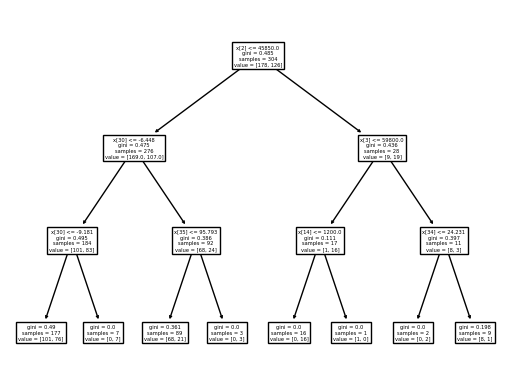

In [31]:
tree.plot_tree(tree_clf)

Model AUC: 0.5702380952380952


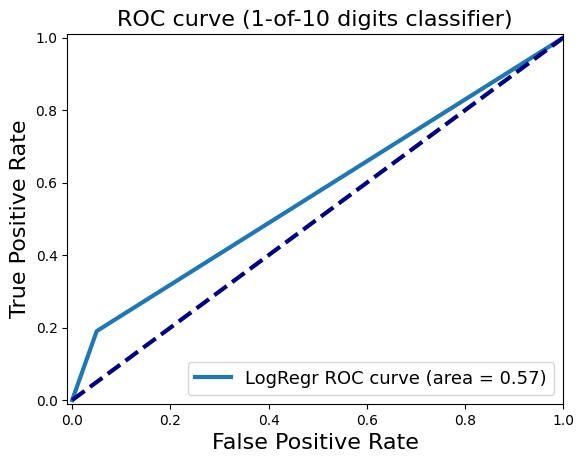

In [33]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, tree_clf.predict(y_train))
roc_auc_lr = auc(fpr_lr, tpr_lr)
print("Model AUC:", roc_auc_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [68]:
def cross_val_scores(tree_clf, X, y, cv=5):
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    cv_results = {'Metric': [], 'Cross-validated Scores': [], 'Mean Cross-validated Score': []}
    
    for metric in scoring_metrics:
        cv_scores = cross_val_score(tree_clf, X, y, cv=cv, scoring=metric)
        cv_results['Metric'].append(metric.capitalize())
        cv_results['Cross-validated Scores'].append(cv_scores)
        mean_score = cv_scores.mean()
        cv_results['Mean Cross-validated Score'].append('{:.3f}'.format(mean_score))
            
    df = pd.DataFrame(cv_results)
    
    return df

cv_scores_df = cross_val_scores(tree_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Accuracy,"[0.5853658536585366, 0.5679012345679012, 0.592...",0.552
1,Precision,"[0.5, 0.3333333333333333, 0.5161290322580645, ...",0.389
2,Recall,"[0.14705882352941177, 0.029411764705882353, 0....",0.202
3,F1,"[0.22727272727272727, 0.05405405405405406, 0.4...",0.243
4,Roc_auc,"[0.5199142156862745, 0.48623279098873595, 0.59...",0.505


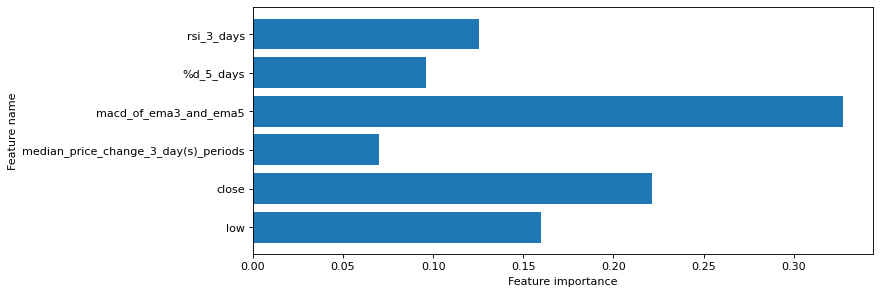

Feature importances: [0.15963019 0.22145399 0.06984482 0.32739678 0.09594844 0.12572579]


In [35]:
feature_importances = tree_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))

# Random Forest

In [69]:
forest_clf = RandomForestClassifier(random_state=0)
grid_values = {
    'max_features': [i for i in range(1, 11)],
    'max_depth': [i for i in range(1, 5)]
}

grid_clf_auc = GridSearchCV(forest_clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.predict(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Test set AUC:  0.5880952380952381
Grid best parameter (max. AUC):  {'max_depth': 3, 'max_features': 10}
Grid best score (AUC):  0.5530617826617827


In [104]:
forest_clf = RandomForestClassifier(max_depth=3, max_features=4, random_state=0)
grid_values = {
    'n_estimators': range(10, 15),
}
grid_clf_auc = GridSearchCV(forest_clf, param_grid = grid_values, scoring = 'roc_auc')
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.predict(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Test set AUC:  0.5452380952380952
Grid best parameter (max. AUC):  {'n_estimators': 11}
Grid best score (AUC):  0.5741406593406594


In [93]:
forest_clf = RandomForestClassifier(random_state=0)
grid_values = {
    'n_estimators': [5, 10, 15, 20, 50],
    'max_depth': range(10, 21),
    'max_features': range(10, 21, 2)
}
random_search_cv = RandomizedSearchCV(estimator=forest_clf, param_distributions= grid_values, cv=5, scoring = 'roc_auc')
random_search_cv.fit(X_train, y_train)

print(random_search_cv.best_estimator_)
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)

RandomForestClassifier(max_depth=20, max_features=20, n_estimators=5,
                       random_state=0)
{'n_estimators': 5, 'max_features': 20, 'max_depth': 20}
0.5360461538461537


In [112]:
forest_clf = RandomForestClassifier(n_estimators=11, max_features=4, max_depth=3, random_state=0)
# forest_clf = random_search_cv.best_estimator_
forest_clf.fit(X_train, y_train)

print_model_evaluation_metrics(forest_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.704
Test Accuracy: 0.608
Train AUC: 0.654
Test AUC: 0.545
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.90      0.73        60
           1       0.57      0.19      0.29        42

    accuracy                           0.61       102
   macro avg       0.59      0.55      0.51       102
weighted avg       0.60      0.61      0.55       102



In [113]:
cv_scores_df = cross_val_scores(forest_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Accuracy,"[0.524390243902439, 0.6419753086419753, 0.6049...",0.562
1,Precision,"[0.3333333333333333, 0.631578947368421, 0.5384...",0.459
2,Recall,"[0.14705882352941177, 0.35294117647058826, 0.4...",0.316
3,F1,"[0.20408163265306123, 0.4528301886792453, 0.46...",0.369
4,Roc_auc,"[0.45373774509803916, 0.5744680851063829, 0.53...",0.518


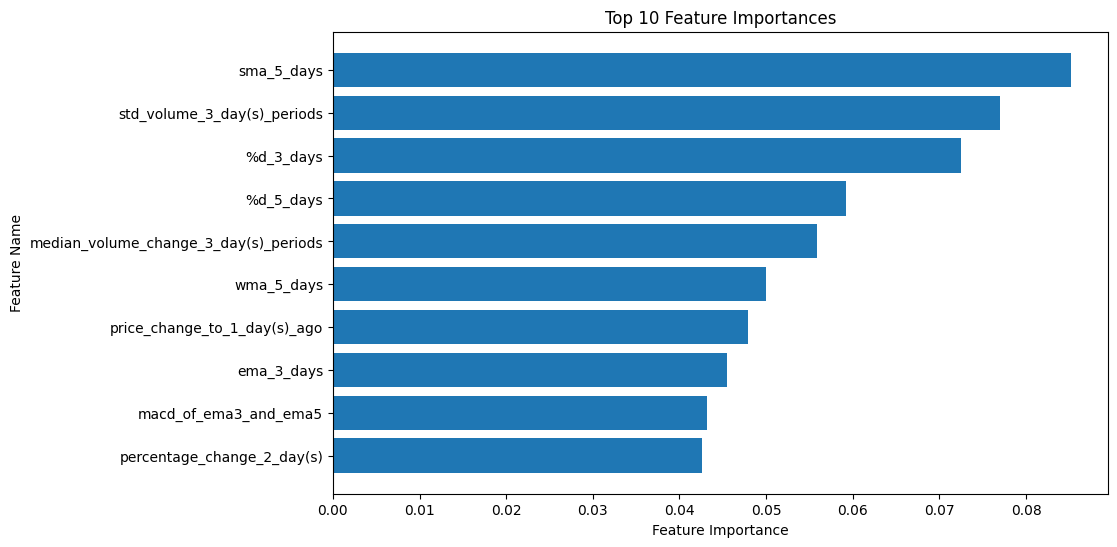

Top 10 Feature Importances:
sma_5_days: 0.08518820654262188
std_volume_3_day(s)_periods: 0.0769911118201305
%d_3_days: 0.07251527765326356
%d_5_days: 0.059264838893966804
median_volume_change_3_day(s)_periods: 0.05583916570418595
wma_5_days: 0.0499800401959813
price_change_to_1_day(s)_ago: 0.0479371163870892
ema_3_days: 0.045497271445191736
macd_of_ema3_and_ema5: 0.04320195332851693
percentage_change_2_day(s): 0.04265363658116064


In [114]:
feature_importances = forest_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

sorted_indices = np.argsort(non_zero_importances)[::-1]
top_10_indices = sorted_indices[:10]

top_10_importances = non_zero_importances[top_10_indices]
top_10_feature_names = non_zero_feature_names[top_10_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_importances)), top_10_importances, align='center')
plt.yticks(np.arange(len(top_10_importances)), top_10_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

print('Top 10 Feature Importances:')
for feature, importance in zip(top_10_feature_names, top_10_importances):
    print(f'{feature}: {importance}')

OOB score

n_estimators    Train Score     OOB Score
10              0.7566          0.5329
20              0.8026          0.5493
30              0.7862          0.5625
40              0.7961          0.5526
50              0.7993          0.5724


/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


60              0.7961          0.5691
70              0.8125          0.5789
80              0.8026          0.5592
90              0.8026          0.5724
100             0.8026          0.5691
110             0.8092          0.5757
120             0.7993          0.5724
130             0.7993          0.5724
140             0.7993          0.5724
150             0.7928          0.5691
160             0.7928          0.5757
170             0.7928          0.5691
180             0.7895          0.5724
190             0.7895          0.5757
200             0.7862          0.5855


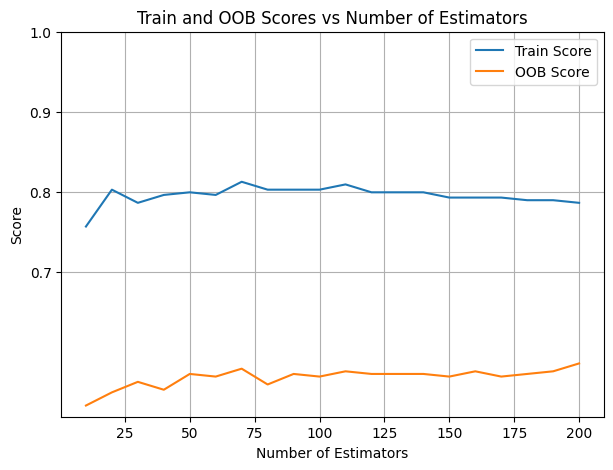

In [75]:
forest_clf_demo = RandomForestClassifier(oob_score=True, random_state=0)
n_estimators_range = range(10, 210, 10)

train_scores = []
oob_scores_val = []

print(f"{'n_estimators':<15} {'Train Score':<15} {'OOB Score'}")
for n_estimators in n_estimators_range:
    forest_clf_demo.set_params(n_estimators=n_estimators, max_depth=20, min_samples_leaf=10)
    forest_clf_demo.fit(X_train, y_train)

    train_score = forest_clf_demo.score(X_train, y_train)
    train_scores.append(train_score)
    
    oob_score_val = forest_clf_demo.oob_score_
    oob_scores_val.append(oob_score_val)

    print(f"{n_estimators:<15} {train_score:<15.4f} {oob_score_val:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(n_estimators_range, train_scores, label='Train Score')
plt.plot(n_estimators_range, oob_scores_val, label='OOB Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Train and OOB Scores vs Number of Estimators')
plt.yticks(np.arange(0.7, 1, 0.1))
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

In [117]:
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

[0]	validation_0-logloss:0.68667
[1]	validation_0-logloss:0.68005
[2]	validation_0-logloss:0.70427


[3]	validation_0-logloss:0.70528
[4]	validation_0-logloss:0.71463
[5]	validation_0-logloss:0.71988
Train Accuracy: 0.812
Test Accuracy: 0.539
Train AUC: 0.778
Test AUC: 0.480
Classification Report:
              precision    recall  f1-score   support

       not 1       0.58      0.82      0.68        60
           1       0.35      0.14      0.20        42

    accuracy                           0.54       102
   macro avg       0.46      0.48      0.44       102
weighted avg       0.48      0.54      0.48       102



/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [118]:
cv_scores_df = cross_val_scores(forest_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Accuracy,"[0.524390243902439, 0.6419753086419753, 0.6049...",0.562
1,Precision,"[0.3333333333333333, 0.631578947368421, 0.5384...",0.459
2,Recall,"[0.14705882352941177, 0.35294117647058826, 0.4...",0.316
3,F1,"[0.20408163265306123, 0.4528301886792453, 0.46...",0.369
4,Roc_auc,"[0.45373774509803916, 0.5744680851063829, 0.53...",0.518


In [172]:
params = {
    "gamma": uniform(0, 0.9),
    "learning_rate": uniform(0.01, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": [5, 10, 15, 20, 25, 50, 100], # default 100
}

search = RandomizedSearchCV(xgb_clf, param_distributions=params, random_state=0, n_iter=200, cv=5, scoring='roc_auc')

search.fit(X, y)

search.best_params_

{'gamma': 0.6782126460049467,
 'learning_rate': 0.011214431910527902,
 'max_depth': 4,
 'n_estimators': 5}

In [173]:
search.best_score_

0.5207730859913275

In [184]:
params = {
    'gamma': 0.6,
    'learning_rate': 0.06,
    'max_depth': 4,
    'n_estimators': 10
}

xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0, **params)
# xgb_clf = search.best_estimator_
xgb_clf.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.67443
[1]	validation_0-logloss:0.67286


[2]	validation_0-logloss:0.67077
[3]	validation_0-logloss:0.66876
[4]	validation_0-logloss:0.66945
[5]	validation_0-logloss:0.66692
[6]	validation_0-logloss:0.66566
[7]	validation_0-logloss:0.66541
[8]	validation_0-logloss:0.66388
[9]	validation_0-logloss:0.66568


/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [185]:
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.688
Test Accuracy: 0.627
Train AUC: 0.624
Test AUC: 0.555
Classification Report:
              precision    recall  f1-score   support

       not 1       0.62      0.97      0.75        60
           1       0.75      0.14      0.24        42

    accuracy                           0.63       102
   macro avg       0.68      0.55      0.50       102
weighted avg       0.67      0.63      0.54       102



In [186]:
cv_scores_df = cross_val_scores(xgb_clf, X, y)
cv_scores_df

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Accuracy,"[0.5365853658536586, 0.5802469135802469, 0.543...",0.534
1,Precision,"[0.25, 0.0, 0.3333333333333333, 0.125, 0.27777...",0.197
2,Recall,"[0.058823529411764705, 0.0, 0.0882352941176470...",0.066
3,F1,"[0.09523809523809523, 0.0, 0.13953488372093023...",0.096
4,Roc_auc,"[0.49969362745098045, 0.5901126408010013, 0.54...",0.491


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

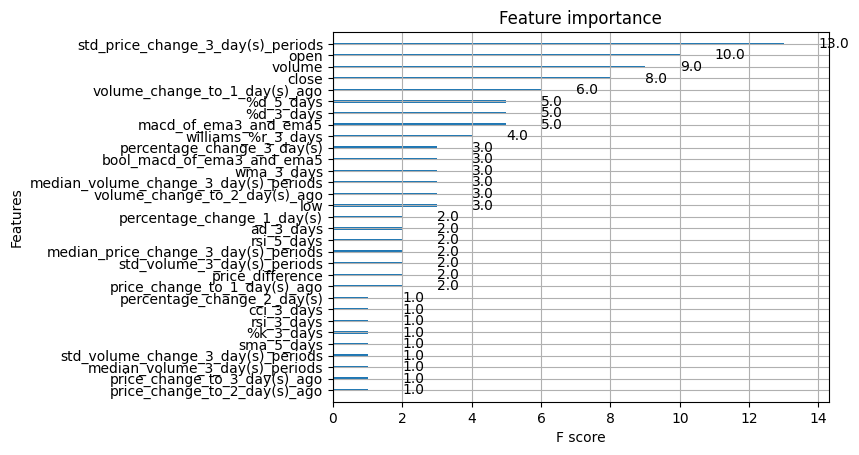

In [187]:
plot_importance(xgb_clf)